look into how btags can help

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.correction import get_pu_weights_function, get_ttbar_weight, get_nlo_weight_function

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
import os
from os.path import join

########## backgrounds ##########
bkgdatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/skimmedbackgrounds_v2.json')))
bkgscales_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/backgrounds_scale_191101.json')))

# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        bkgdatasets[tag] = bkgdatasets_[group][tag]

# flatten scales
bkgscales = {}
for group in bkgscales_:
    for tag in bkgscales_[group]:
        bkgscales[tag] = bkgscales_[group][tag]

lumi = 59.74*1e3
for k in bkgscales:
    bkgscales[k] *= lumi

# mapping
bkgmapping = {}
for k in bkgdatasets_: bkgmapping[k] = list(bkgdatasets_[k])
####################################

########## data ##########
datadatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/Data/Samples/skimmed_control_data2018_v2.json')))
datadatasets = datadatasets_
datamapping = {'data': list('ABCD')}
####################################

########## combine together ##########
datasets = {}
datasets.update(bkgdatasets)
# datasets.update(datadatasets) # skip data for now

mapping = {}
mapping.update(bkgmapping)
# mapping.update(datamapping)
####################################

In [3]:
# using regular expressions on dataset name to select just the data
# another method would be to fill a separate data histogram
import re
notdata = re.compile('(?!data)')

# common plotting options
fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

In [5]:

"""AK4PFCHSJets b-tagging(deepcsv, deepjet) result."""
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#b-tagged AK4CHS jets/event", 10, 0, 10)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        
        self._accumulator = processor.dict_accumulator({
            'deepcsv-loose': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'deepcsv-medium': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'deepcsv-tight': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'deepjet-loose': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'deepjet-medium': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'deepjet-tight': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
        })
        
        ## corrections NOT appplied for now
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        pvmask = df['metfilters_PrimaryVertexFilter']
        wgts.add('primaryvtx', pvmask)
        
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        
        ak4jets = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_ak4PFJetsCHS_p4'],
            px=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fX'],
            py=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fY'],
            pz=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fZ'],
            energy=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fT'],
            jetid=df['akjet_ak4PFJetsCHS_jetid'],
            deepcsv=df['hftagscore_DeepCSV_b'],
            deepjet=df['hftagscore_DeepFlavour_b'],
        )
        deepcsv_loose = np.bitwise_and(ak4jets.deepcsv, 1<<0)==(1<<0)
        deepcsv_medium = np.bitwise_and(ak4jets.deepcsv, 1<<1)==(1<<1)
        deepcsv_tight = np.bitwise_and(ak4jets.deepcsv, 1<<2)==(1<<2)
        deepjet_loose = np.bitwise_and(ak4jets.deepjet, 1<<0)==(1<<0)
        deepjet_medium = np.bitwise_and(ak4jets.deepjet, 1<<1)==(1<<1)
        deepjet_tight = np.bitwise_and(ak4jets.deepjet, 1<<2)==(1<<2)
        ak4jets.add_attributes(deepcsvLoose=deepcsv_loose,
                               deepcsvMedium=deepcsv_medium,
                               deepcsvTight=deepcsv_tight,
                               deepjetLoose=deepjet_loose,
                               deepjetMedium=deepjet_medium,
                               deepjetTight=deepjet_tight,
                               )
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        ## __ twoleptonjets__
        twoleptonjets = leptonjets.counts>=2
        ak4jets = ak4jets[twoleptonjets]
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        ## __isControl__
        leptonjets_ = dileptonjets[isControl]
        ak4jets = ak4jets[isControl]
        if leptonjets_.size==0: return output
        wgt = wgt[isControl]
        lj0 = lj0[isControl]
        lj1 = lj1[isControl]
        channel_ = channel_[isControl]

        ak4jets=ak4jets[ak4jets.jetid&(ak4jets.pt>30)&(np.abs(ak4jets.eta)<2.5)]
        if ak4jets.size==0: return output
        
        output['deepcsv-loose'].fill(dataset=dataset, multiplicity=ak4jets.deepcsvLoose.sum(), weight=wgt, channel=channel_)
        output['deepcsv-medium'].fill(dataset=dataset, multiplicity=ak4jets.deepcsvMedium.sum(), weight=wgt, channel=channel_)
        output['deepcsv-tight'].fill(dataset=dataset, multiplicity=ak4jets.deepcsvTight.sum(), weight=wgt, channel=channel_)
        output['deepjet-loose'].fill(dataset=dataset, multiplicity=ak4jets.deepjetLoose.sum(), weight=wgt, channel=channel_)
        output['deepjet-medium'].fill(dataset=dataset, multiplicity=ak4jets.deepjetMedium.sum(), weight=wgt, channel=channel_)
        output['deepjet-tight'].fill(dataset=dataset, multiplicity=ak4jets.deepjetTight.sum(), weight=wgt, channel=channel_)
        
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [6]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 21/21 [00:03<00:00,  1.83items/s]


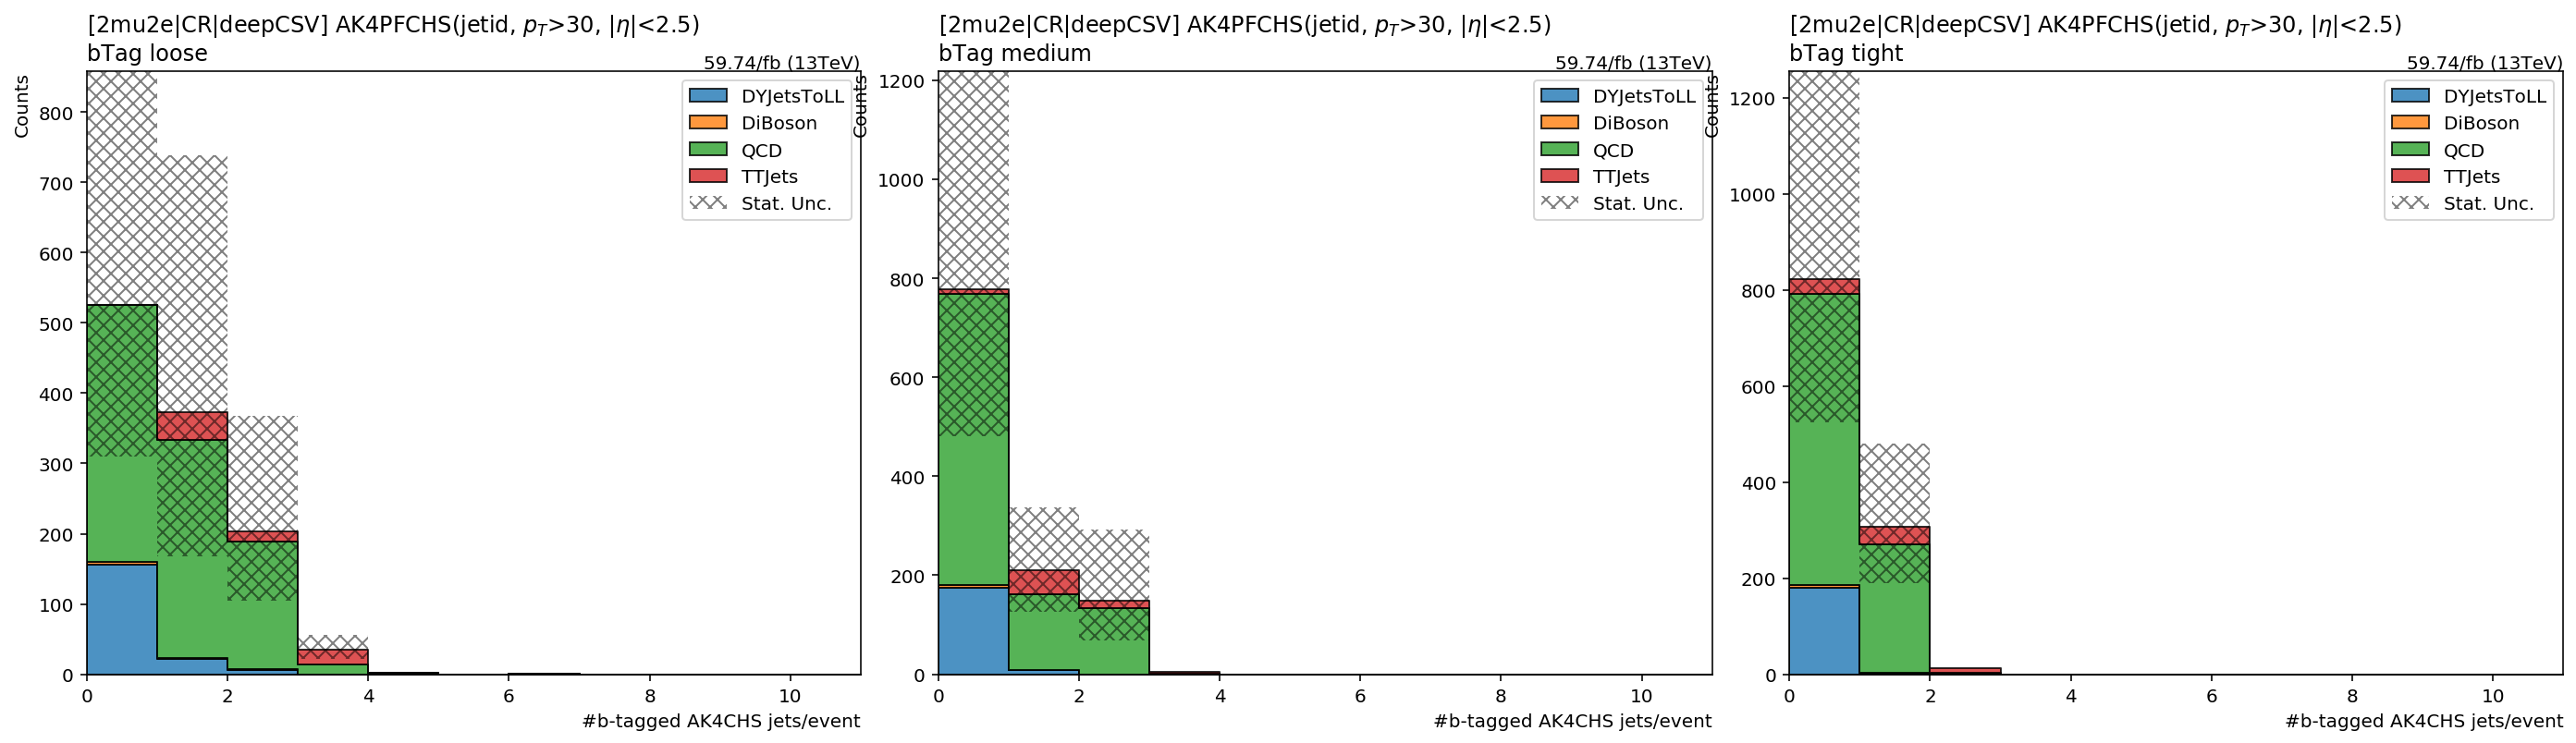

In [9]:
fig, axes=plt.subplots(1,3,figsize=(24,6))
fig.subplots_adjust(hspace=.07, wspace=0.1)
for i, label in enumerate(['loose', 'medium', 'tight']):
    hist.plot1d(output[f'deepcsv-{label}_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=axes[i],
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)

logy=False
for ax in axes:
    ax.autoscale(axis='both', tight=True)
    if logy:
        ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
    leg=ax.legend()
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'59.74/fb (13TeV)',
            ha='right', va='bottom', transform=ax.transAxes)

axes[0].set_title('[2mu2e|CR|deepCSV] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5)\nbTag loose', x=0.0, ha="left")
axes[1].set_title('[2mu2e|CR|deepCSV] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5)\nbTag medium', x=0.0, ha="left")
axes[2].set_title('[2mu2e|CR|deepCSV] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5)\nbTag tight', x=0.0, ha="left");

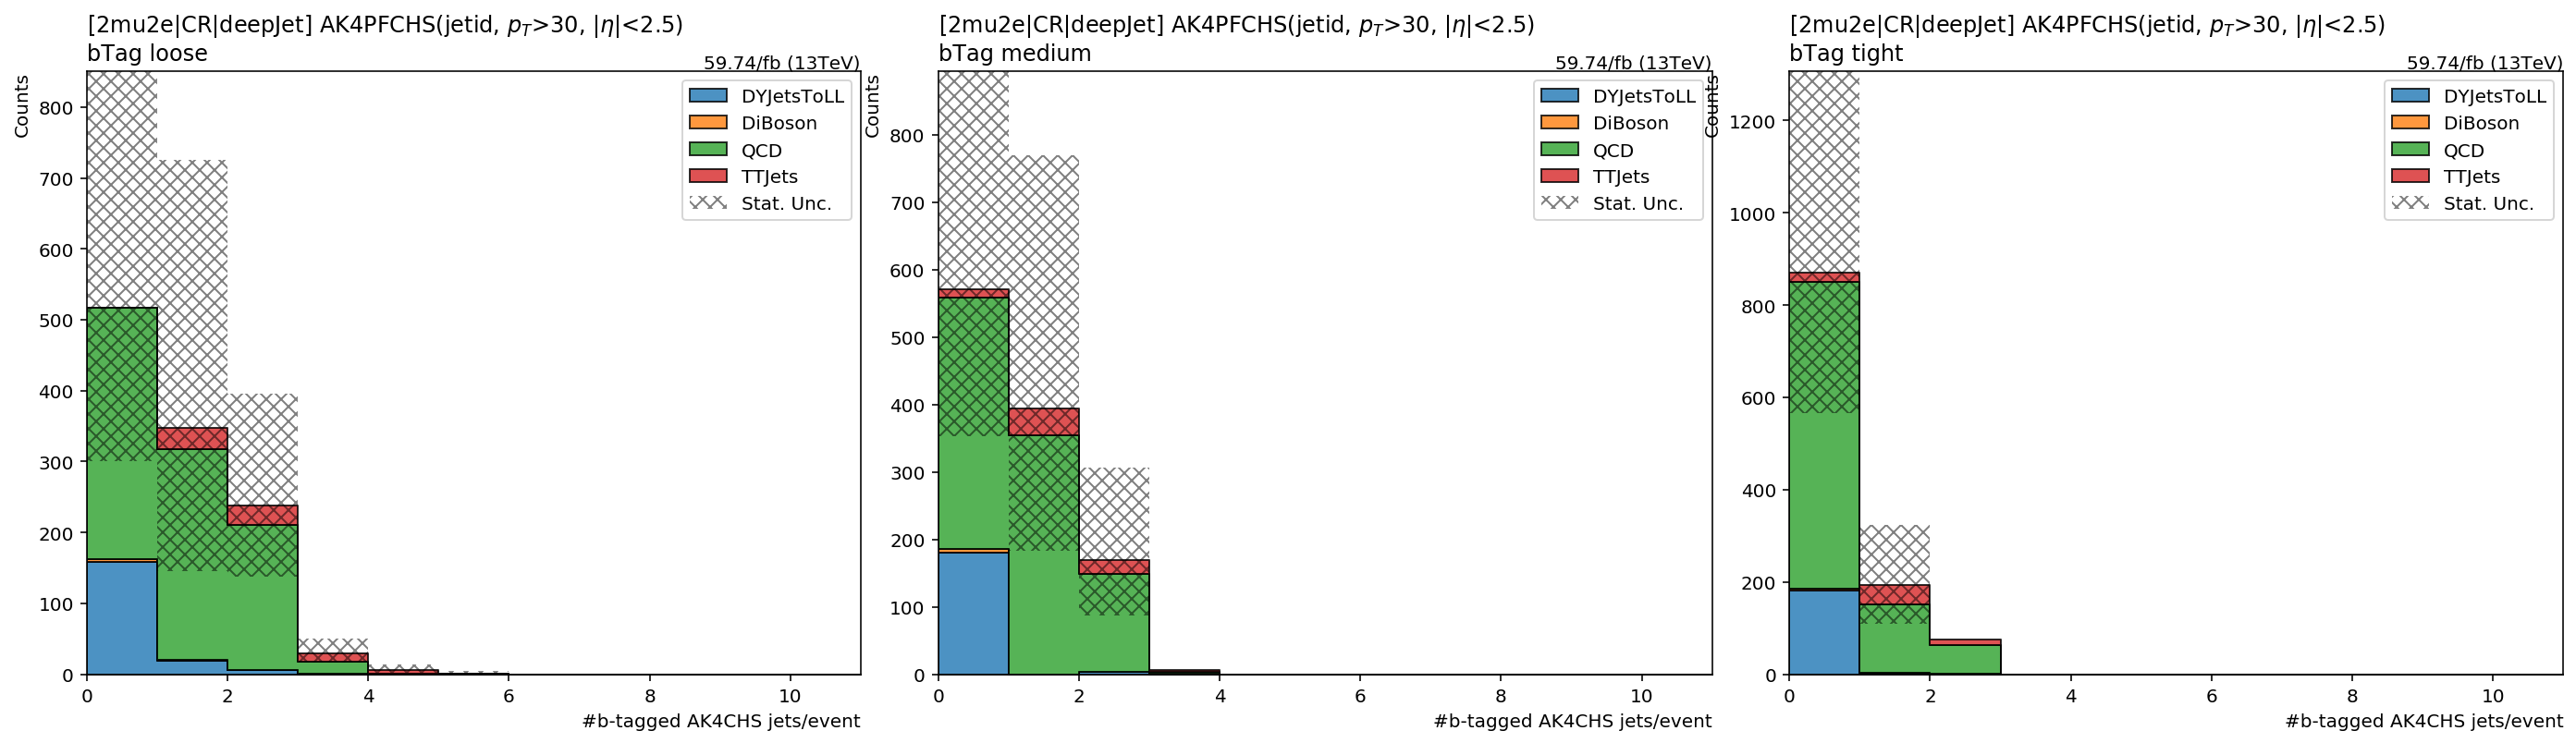

In [11]:
fig, axes=plt.subplots(1,3,figsize=(24,6))
fig.subplots_adjust(hspace=.1, wspace=0.1)
for i, label in enumerate(['loose', 'medium', 'tight']):
    hist.plot1d(output[f'deepjet-{label}_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=axes[i],
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)

logy=False
for ax in axes:
    ax.autoscale(axis='both', tight=True)
    if logy:
        ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
    leg=ax.legend()
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'59.74/fb (13TeV)',
            ha='right', va='bottom', transform=ax.transAxes)

axes[0].set_title('[2mu2e|CR|deepJet] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5)\nbTag loose', x=0.0, ha="left")
axes[1].set_title('[2mu2e|CR|deepJet] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5)\nbTag medium', x=0.0, ha="left")
axes[2].set_title('[2mu2e|CR|deepJet] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5)\nbTag tight', x=0.0, ha="left");

## all region

In [4]:

"""AK4PFCHSJets b-tagging(deepcsv, deepjet) result."""
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#b-tagged AK4CHS jets/event", 10, 0, 10)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        
        self._accumulator = processor.dict_accumulator({
            'deepcsv-loose': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'deepcsv-medium': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'deepcsv-tight': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'deepjet-loose': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'deepjet-medium': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'deepjet-tight': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
        })
        
        ## corrections NOT applied for now
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        pvmask = df['metfilters_PrimaryVertexFilter']
        wgts.add('primaryvtx', pvmask)
        
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        
        ak4jets = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_ak4PFJetsCHS_p4'],
            px=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fX'],
            py=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fY'],
            pz=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fZ'],
            energy=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fT'],
            jetid=df['akjet_ak4PFJetsCHS_jetid'],
            deepcsv=df['hftagscore_DeepCSV_b'],
            deepjet=df['hftagscore_DeepFlavour_b'],
        )
        deepcsv_loose = np.bitwise_and(ak4jets.deepcsv, 1<<0)==(1<<0)
        deepcsv_medium = np.bitwise_and(ak4jets.deepcsv, 1<<1)==(1<<1)
        deepcsv_tight = np.bitwise_and(ak4jets.deepcsv, 1<<2)==(1<<2)
        deepjet_loose = np.bitwise_and(ak4jets.deepjet, 1<<0)==(1<<0)
        deepjet_medium = np.bitwise_and(ak4jets.deepjet, 1<<1)==(1<<1)
        deepjet_tight = np.bitwise_and(ak4jets.deepjet, 1<<2)==(1<<2)
        ak4jets.add_attributes(deepcsvLoose=deepcsv_loose,
                               deepcsvMedium=deepcsv_medium,
                               deepcsvTight=deepcsv_tight,
                               deepjetLoose=deepjet_loose,
                               deepjetMedium=deepjet_medium,
                               deepjetTight=deepjet_tight,
                               )
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        ## __ twoleptonjets__
        twoleptonjets = leptonjets.counts>=2
        ak4jets = ak4jets[twoleptonjets]
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        ## __isControl__
        leptonjets_ = dileptonjets
        ak4jets = ak4jets
        if leptonjets_.size==0: return output
        wgt = wgt
        lj0 = lj0
        lj1 = lj1
        channel_ = channel_

        ak4jets=ak4jets[ak4jets.jetid&(ak4jets.pt>30)&(np.abs(ak4jets.eta)<2.5)]
        if ak4jets.size==0: return output
        
        output['deepcsv-loose'].fill(dataset=dataset, multiplicity=ak4jets.deepcsvLoose.sum(), weight=wgt, channel=channel_)
        output['deepcsv-medium'].fill(dataset=dataset, multiplicity=ak4jets.deepcsvMedium.sum(), weight=wgt, channel=channel_)
        output['deepcsv-tight'].fill(dataset=dataset, multiplicity=ak4jets.deepcsvTight.sum(), weight=wgt, channel=channel_)
        output['deepjet-loose'].fill(dataset=dataset, multiplicity=ak4jets.deepjetLoose.sum(), weight=wgt, channel=channel_)
        output['deepjet-medium'].fill(dataset=dataset, multiplicity=ak4jets.deepjetMedium.sum(), weight=wgt, channel=channel_)
        output['deepjet-tight'].fill(dataset=dataset, multiplicity=ak4jets.deepjetTight.sum(), weight=wgt, channel=channel_)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [5]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 21/21 [00:03<00:00,  1.83items/s]


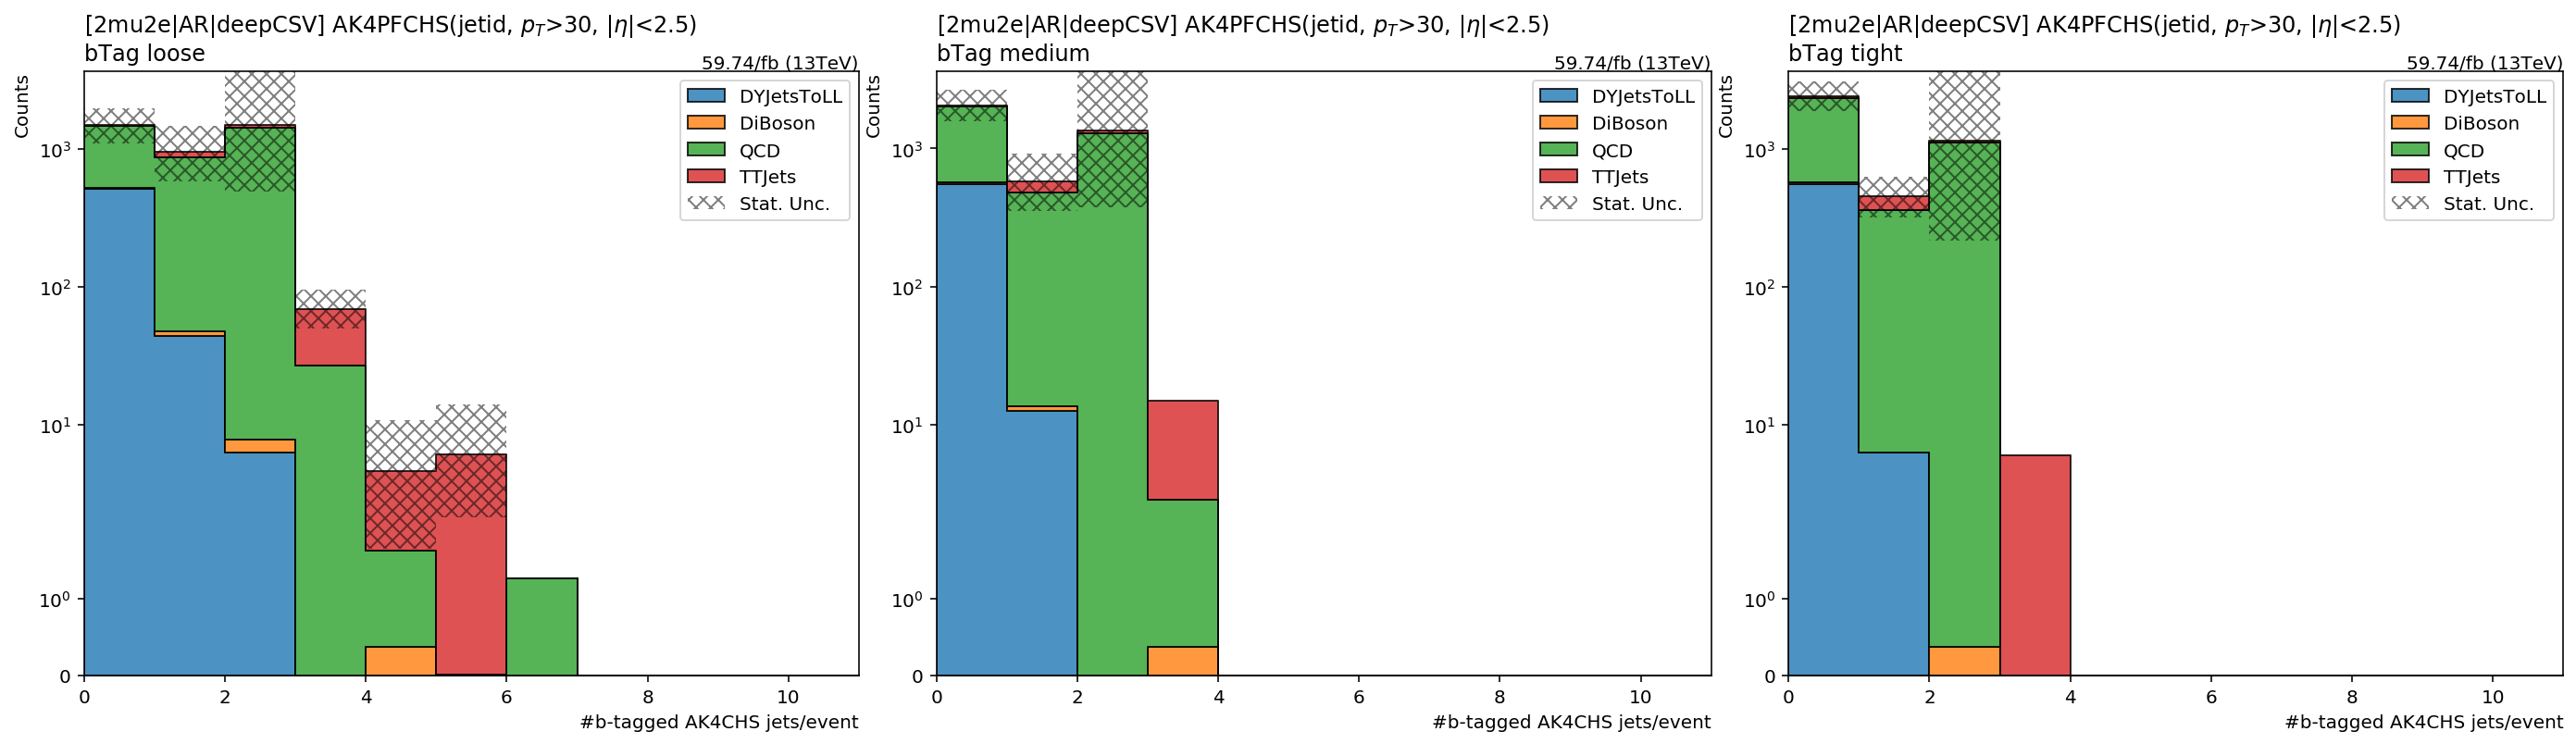

In [6]:
fig, axes=plt.subplots(1,3,figsize=(24,6))
fig.subplots_adjust(hspace=.1, wspace=0.1)
for i, label in enumerate(['loose', 'medium', 'tight']):
    hist.plot1d(output[f'deepcsv-{label}_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=axes[i],
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)

logy=True
for ax in axes:
    ax.autoscale(axis='both', tight=True)
    if logy:
        ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
    leg=ax.legend()
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'59.74/fb (13TeV)',
            ha='right', va='bottom', transform=ax.transAxes)

axes[0].set_title('[2mu2e|AR|deepCSV] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5)\nbTag loose', x=0.0, ha="left")
axes[1].set_title('[2mu2e|AR|deepCSV] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5)\nbTag medium', x=0.0, ha="left")
axes[2].set_title('[2mu2e|AR|deepCSV] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5)\nbTag tight', x=0.0, ha="left");

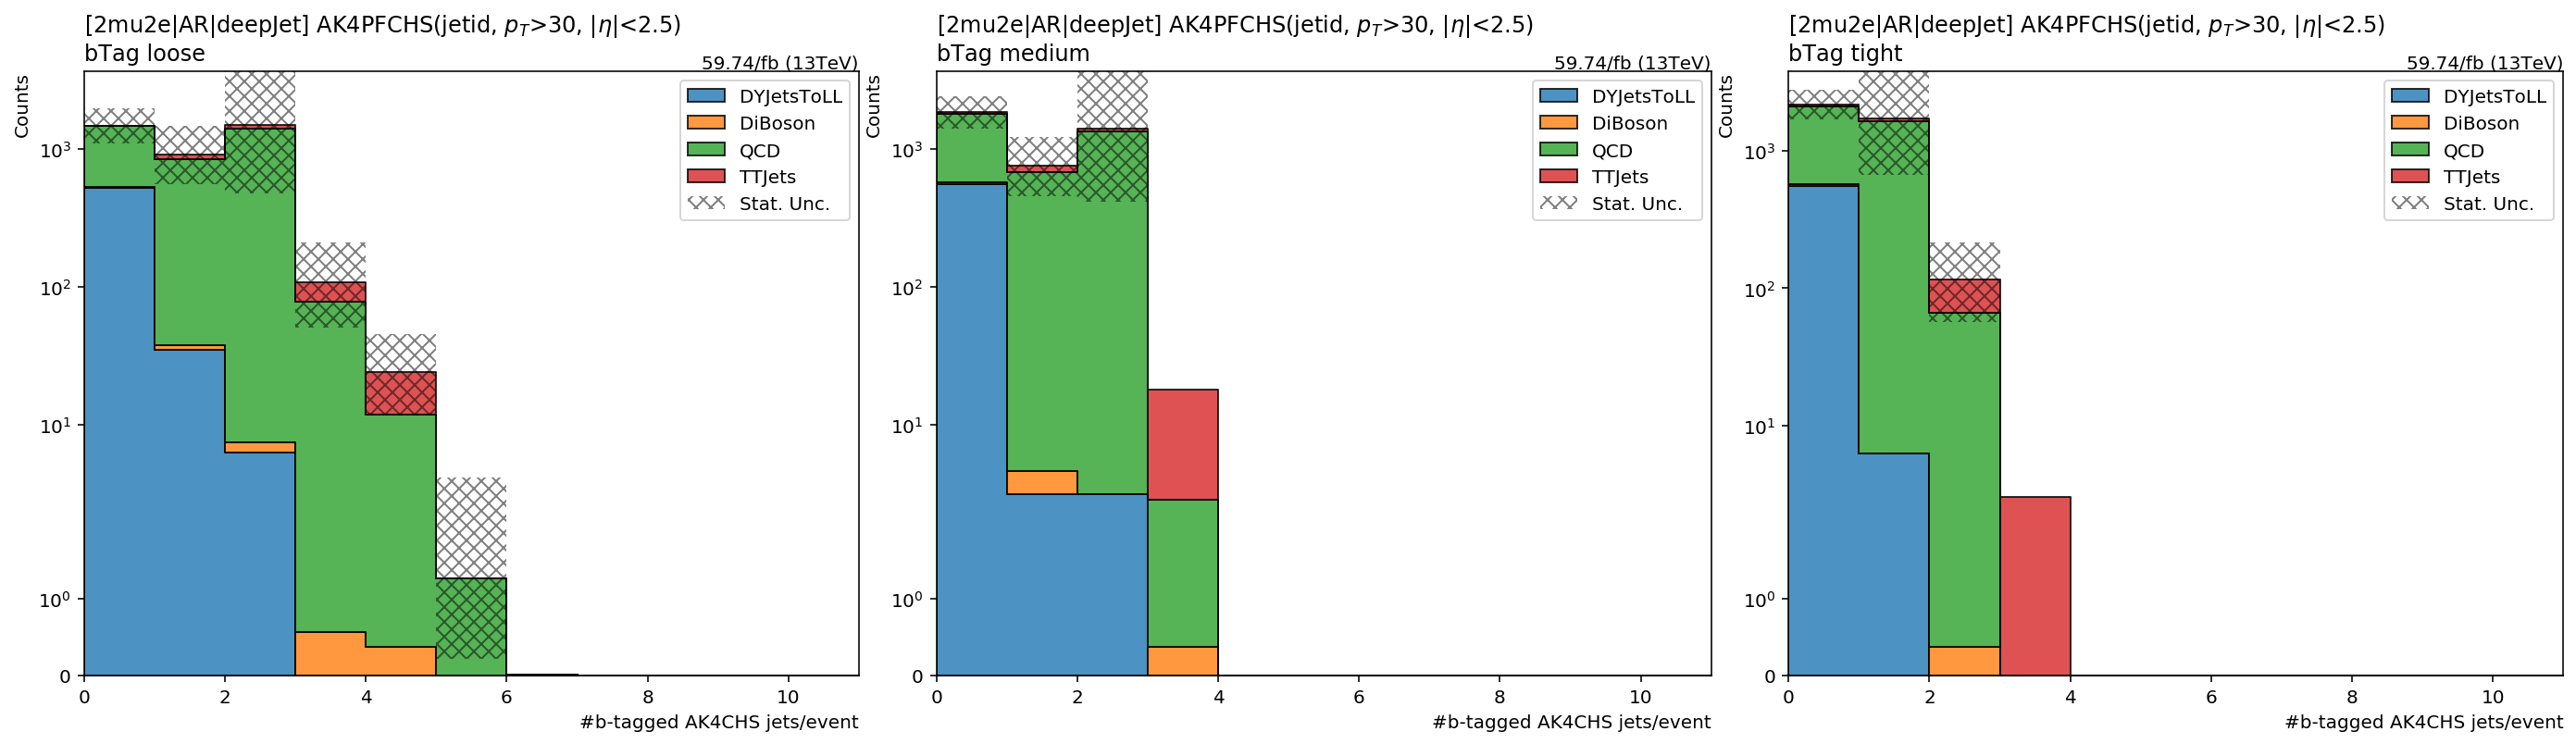

In [16]:
fig, axes=plt.subplots(1,3,figsize=(24,6))
fig.subplots_adjust(hspace=.07, wspace=0.1)
for i, label in enumerate(['loose', 'medium', 'tight']):
    hist.plot1d(output[f'deepjet-{label}_cat'][notdata].integrate('channel', slice(1,2)),
                   overlay='cat',
                   ax=axes[i],
                   clear=False,
                   stack=True,
                   overflow='over',
                   line_opts=None,
                   fill_opts=fill_opts,
                   error_opts=error_opts)

logy=True
for ax in axes:
    ax.autoscale(axis='both', tight=True)
    if logy:
        ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
    leg=ax.legend()
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.text(1,1,'59.74/fb (13TeV)',
            ha='right', va='bottom', transform=ax.transAxes)

axes[0].set_title('[2mu2e|AR|deepJet] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5)\nbTag loose', x=0.0, ha="left")
axes[1].set_title('[2mu2e|AR|deepJet] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5)\nbTag medium', x=0.0, ha="left")
axes[2].set_title('[2mu2e|AR|deepJet] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5)\nbTag tight', x=0.0, ha="left");

# signal

In [17]:
dataset4mu_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_4mu_v2-1.json')))
dataset2mu2e_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_2mu2e_v2-1.json')))

In [18]:

"""AK4PFCHSJets b-tagging(deepcsv, deepjet) result."""
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'datasets')
        multiplicity_axis = hist.Bin("multiplicity", "#b-tagged AK4CHS jets/event", 10, 0, 10)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        
        self._accumulator = processor.dict_accumulator({
            'deepcsv-loose': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'deepcsv-medium': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'deepcsv-tight': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'deepjet-loose': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'deepjet-medium': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'deepjet-tight': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
        })
        
        ## corrections NOT applied for now
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
#         if len(dataset)!=1:
#             wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        pvmask = df['metfilters_PrimaryVertexFilter']
        wgts.add('primaryvtx', pvmask)
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        
        ak4jets = JaggedCandidateArray.candidatesfromcounts(
            df['akjet_ak4PFJetsCHS_p4'],
            px=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fX'],
            py=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fY'],
            pz=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fZ'],
            energy=df['akjet_ak4PFJetsCHS_p4.fCoordinates.fT'],
            jetid=df['akjet_ak4PFJetsCHS_jetid'],
            deepcsv=df['hftagscore_DeepCSV_b'],
            deepjet=df['hftagscore_DeepFlavour_b'],
        )
        deepcsv_loose = np.bitwise_and(ak4jets.deepcsv, 1<<0)==(1<<0)
        deepcsv_medium = np.bitwise_and(ak4jets.deepcsv, 1<<1)==(1<<1)
        deepcsv_tight = np.bitwise_and(ak4jets.deepcsv, 1<<2)==(1<<2)
        deepjet_loose = np.bitwise_and(ak4jets.deepjet, 1<<0)==(1<<0)
        deepjet_medium = np.bitwise_and(ak4jets.deepjet, 1<<1)==(1<<1)
        deepjet_tight = np.bitwise_and(ak4jets.deepjet, 1<<2)==(1<<2)
        ak4jets.add_attributes(deepcsvLoose=deepcsv_loose,
                               deepcsvMedium=deepcsv_medium,
                               deepcsvTight=deepcsv_tight,
                               deepjetLoose=deepjet_loose,
                               deepjetMedium=deepjet_medium,
                               deepjetTight=deepjet_tight,
                               )
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        ## __ twoleptonjets__
        twoleptonjets = leptonjets.counts>=2
        ak4jets = ak4jets[twoleptonjets]
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        ## __isControl__
        leptonjets_ = dileptonjets
        ak4jets = ak4jets
        if leptonjets_.size==0: return output
        wgt = wgt
        lj0 = lj0
        lj1 = lj1
        channel_ = channel_

        ak4jets=ak4jets[ak4jets.jetid&(ak4jets.pt>30)&(np.abs(ak4jets.eta)<2.5)]
        if ak4jets.size==0: return output

        output['deepcsv-loose'].fill(dataset=dataset, multiplicity=ak4jets.deepcsvLoose.sum(), weight=wgt, channel=channel_)
        output['deepcsv-medium'].fill(dataset=dataset, multiplicity=ak4jets.deepcsvMedium.sum(), weight=wgt, channel=channel_)
        output['deepcsv-tight'].fill(dataset=dataset, multiplicity=ak4jets.deepcsvTight.sum(), weight=wgt, channel=channel_)
        output['deepjet-loose'].fill(dataset=dataset, multiplicity=ak4jets.deepjetLoose.sum(), weight=wgt, channel=channel_)
        output['deepjet-medium'].fill(dataset=dataset, multiplicity=ak4jets.deepjetMedium.sum(), weight=wgt, channel=channel_)
        output['deepjet-tight'].fill(dataset=dataset, multiplicity=ak4jets.deepjetTight.sum(), weight=wgt, channel=channel_)
        
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [19]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
    
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                  maxchunks=1
                                 )

Processing: 100%|██████████| 16/16 [00:07<00:00,  2.28items/s]


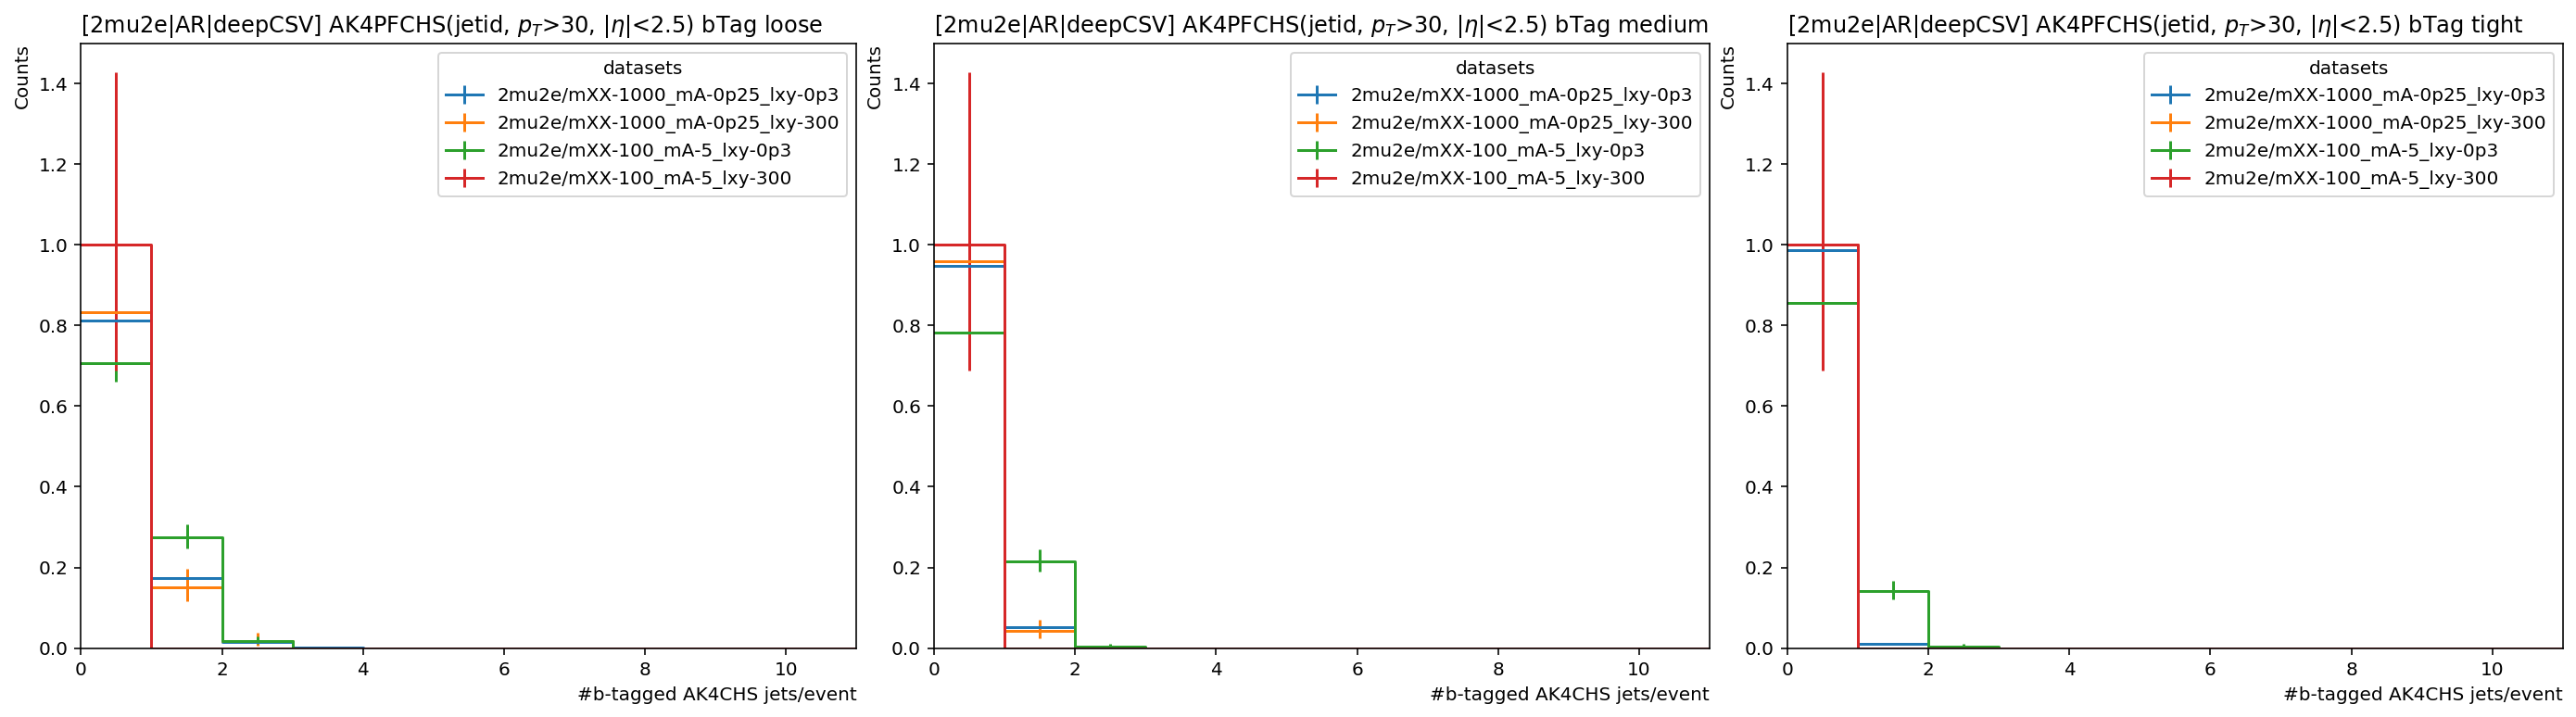

In [22]:
fig, axes=plt.subplots(1,3,figsize=(24,6))
fig.subplots_adjust(hspace=.07, wspace=0.1)
for i, label in enumerate(['loose', 'medium', 'tight']):
    hist.plot1d(output[f'deepcsv-{label}']['2mu2e/*'].integrate('channel', slice(1,2)),
                   overlay='dataset',
                   ax=axes[i],
                   density=True,
                   overflow='over',)
logy=False
for ax in axes:
    ax.autoscale(axis='x', tight=True)
    if logy:
        ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
#     ax.text(1,1,'59.74/fb (13TeV)',
#             ha='right', va='bottom', transform=ax.transAxes)

axes[0].set_title('[2mu2e|AR|deepCSV] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5) bTag loose', x=0.0, ha="left")
axes[1].set_title('[2mu2e|AR|deepCSV] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5) bTag medium', x=0.0, ha="left")
axes[2].set_title('[2mu2e|AR|deepCSV] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5) bTag tight', x=0.0, ha="left");

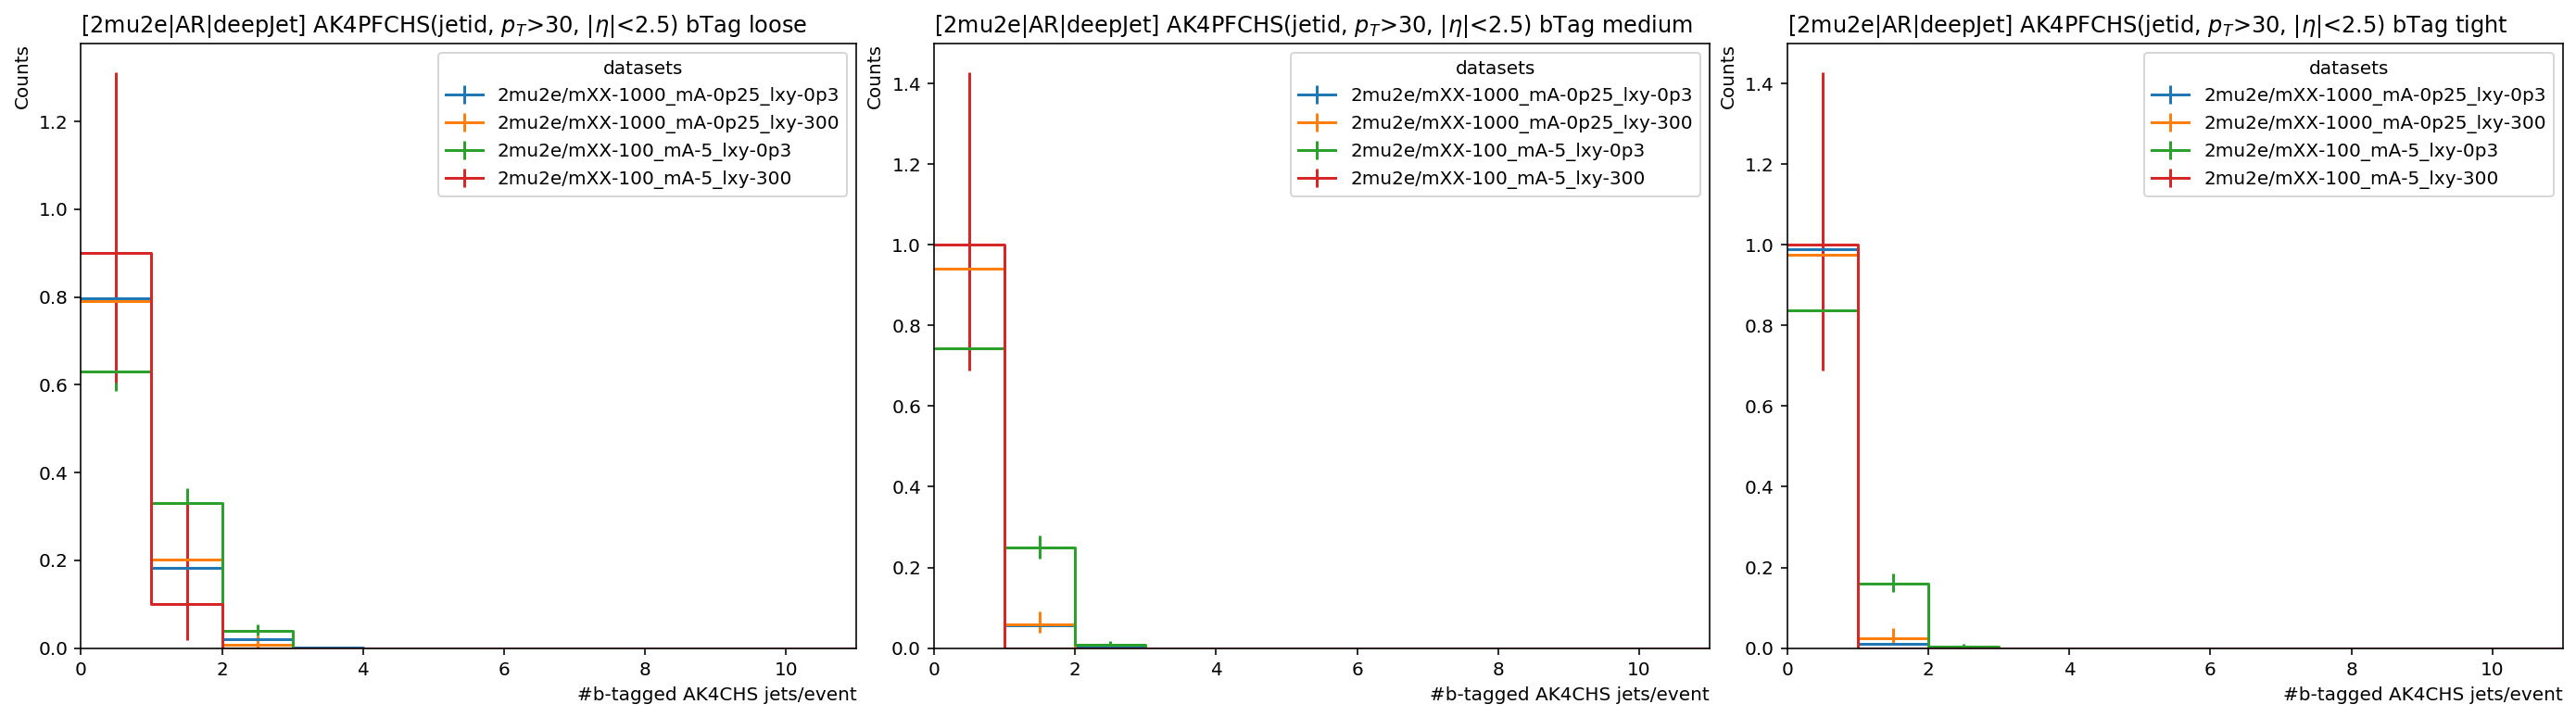

In [21]:
fig, axes=plt.subplots(1,3,figsize=(24,6))
fig.subplots_adjust(hspace=.07, wspace=0.1)
for i, label in enumerate(['loose', 'medium', 'tight']):
    hist.plot1d(output[f'deepjet-{label}']['2mu2e/*'].integrate('channel', slice(1,2)),
                   overlay='dataset',
                   ax=axes[i],
                   density=True,
                   overflow='over',)
logy=False
for ax in axes:
    ax.autoscale(axis='x', tight=True)
    if logy:
        ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
#     ax.text(1,1,'59.74/fb (13TeV)',
#             ha='right', va='bottom', transform=ax.transAxes)

axes[0].set_title('[2mu2e|AR|deepJet] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5) bTag loose', x=0.0, ha="left")
axes[1].set_title('[2mu2e|AR|deepJet] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5) bTag medium', x=0.0, ha="left")
axes[2].set_title('[2mu2e|AR|deepJet] AK4PFCHS(jetid, $p_T$>30, |$\eta$|<2.5) bTag tight', x=0.0, ha="left");

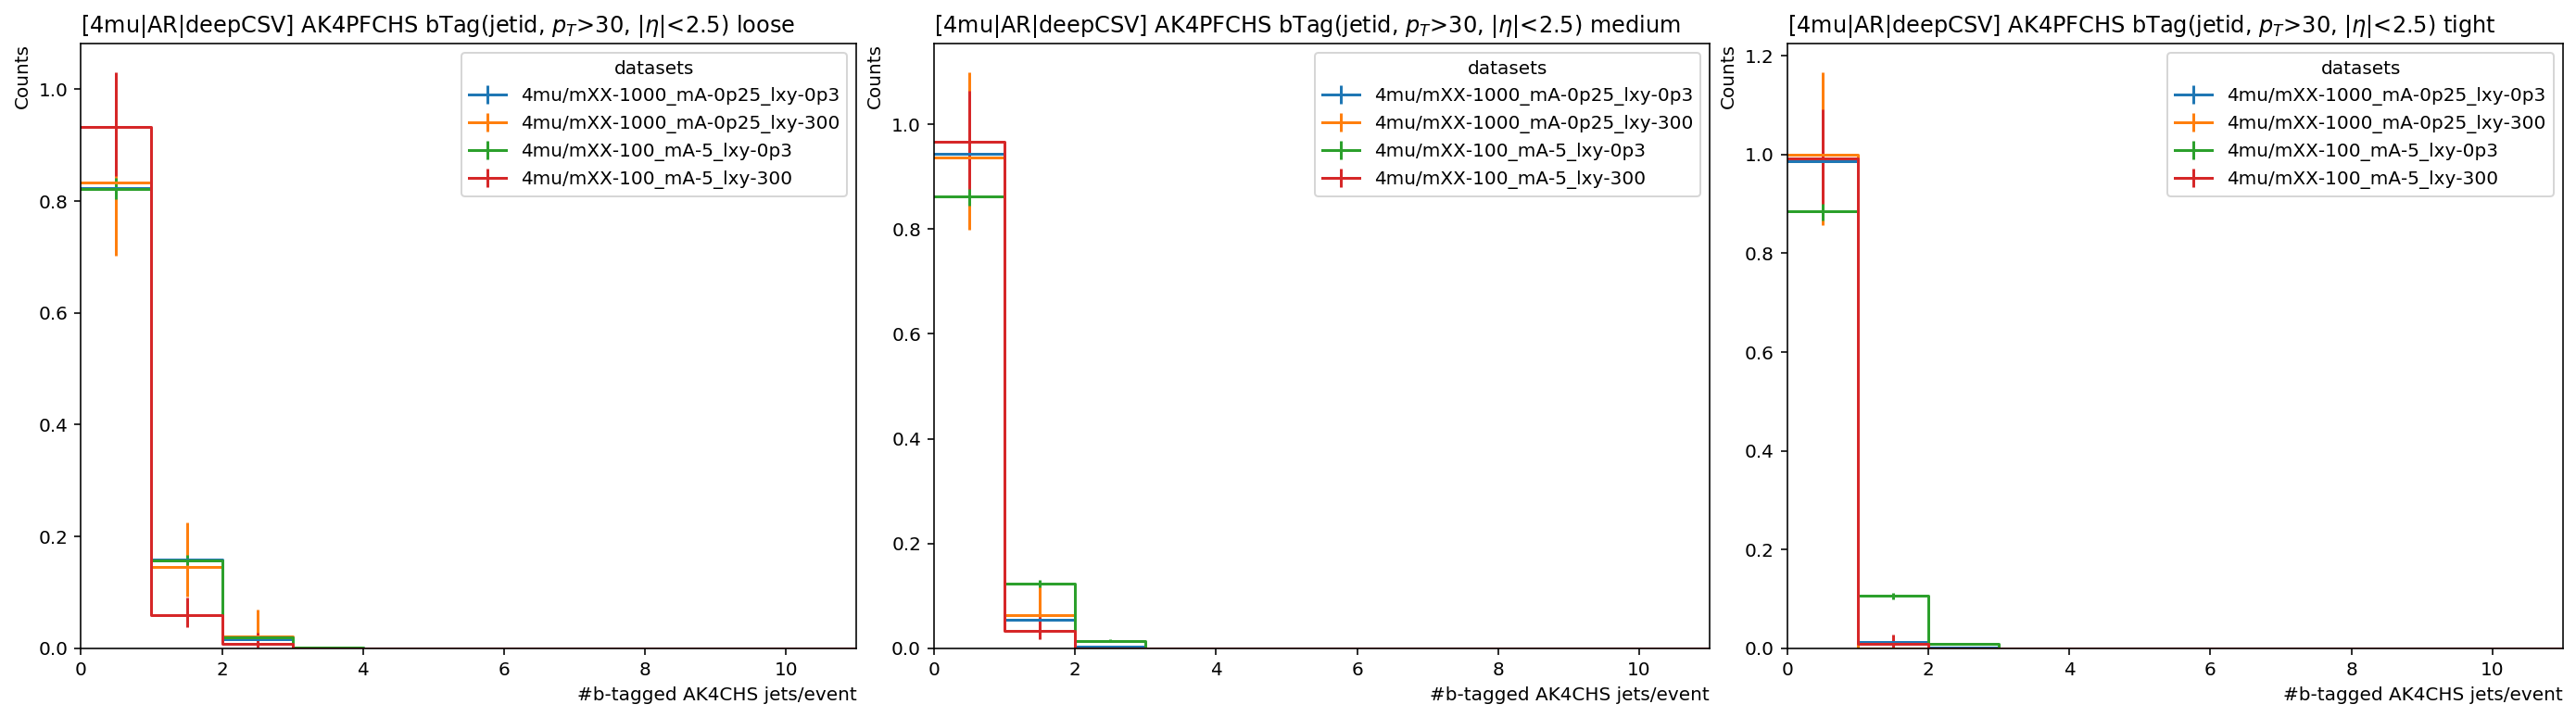

In [23]:
fig, axes=plt.subplots(1,3,figsize=(24,6))
fig.subplots_adjust(hspace=.07, wspace=0.1)
for i, label in enumerate(['loose', 'medium', 'tight']):
    hist.plot1d(output[f'deepcsv-{label}']['4mu/*'].integrate('channel', slice(2,3)),
                   overlay='dataset',
                   ax=axes[i],
                   density=True,
                   overflow='over',)
logy=False
for ax in axes:
    ax.autoscale(axis='x', tight=True)
    if logy:
        ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
#     ax.text(1,1,'59.74/fb (13TeV)',
#             ha='right', va='bottom', transform=ax.transAxes)

axes[0].set_title('[4mu|AR|deepCSV] AK4PFCHS bTag(jetid, $p_T$>30, |$\eta$|<2.5) loose', x=0.0, ha="left")
axes[1].set_title('[4mu|AR|deepCSV] AK4PFCHS bTag(jetid, $p_T$>30, |$\eta$|<2.5) medium', x=0.0, ha="left")
axes[2].set_title('[4mu|AR|deepCSV] AK4PFCHS bTag(jetid, $p_T$>30, |$\eta$|<2.5) tight', x=0.0, ha="left");

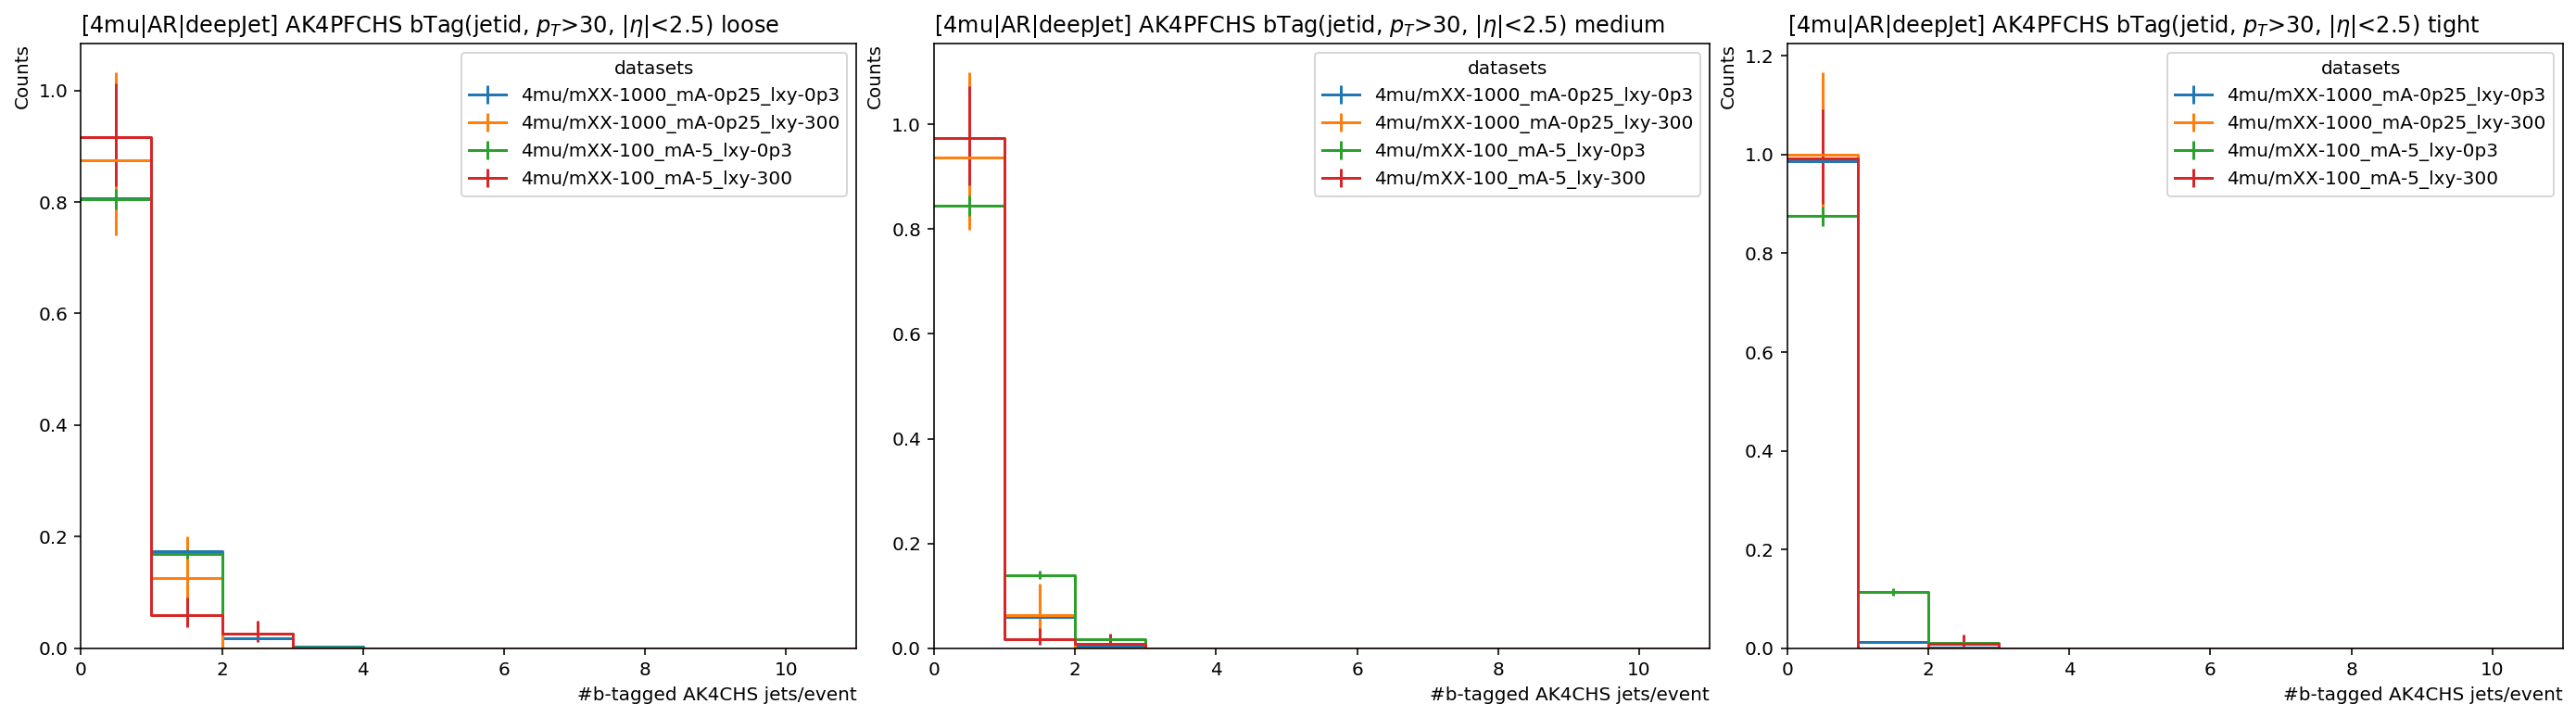

In [24]:
fig, axes=plt.subplots(1,3,figsize=(24,6))
fig.subplots_adjust(hspace=.07, wspace=0.1)
for i, label in enumerate(['loose', 'medium', 'tight']):
    hist.plot1d(output[f'deepjet-{label}']['4mu/*'].integrate('channel', slice(2,3)),
                   overlay='dataset',
                   ax=axes[i],
                   density=True,
                   overflow='over',)
logy=False
for ax in axes:
    ax.autoscale(axis='x', tight=True)
    if logy:
        ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
#     ax.text(1,1,'59.74/fb (13TeV)',
#             ha='right', va='bottom', transform=ax.transAxes)

axes[0].set_title('[4mu|AR|deepJet] AK4PFCHS bTag(jetid, $p_T$>30, |$\eta$|<2.5) loose', x=0.0, ha="left")
axes[1].set_title('[4mu|AR|deepJet] AK4PFCHS bTag(jetid, $p_T$>30, |$\eta$|<2.5) medium', x=0.0, ha="left")
axes[2].set_title('[4mu|AR|deepJet] AK4PFCHS bTag(jetid, $p_T$>30, |$\eta$|<2.5) tight', x=0.0, ha="left");